In [1]:
#download libraries if not already installed
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
except ImportError:
    import os
    os.system('pip install numpy matplotlib')

try:
    import keras
    from keras.models import resnet
except ImportError:
    import os
    os.system(' pip install keras-resnet ')

try:
    import tensorflow as tf
except ImportError:
    import os
    os.system('pip install tensorflow')

# preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
pos=np.load('data_npy/100_3.npy')
vid=np.load('data_video/100_3.npy')
midline=np.load('data_midline/100_3_consistent.npy')
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]


def angle_between_2vec(vec1, vec2, axis=2):
    """Calculate the angle between two vectors."""
    return np.arctan2(
        np.cross(vec1, vec2, axis=axis),
        np.sum(vec1 * vec2, axis=axis)
    )


phi= np.arctan2(head[:,:,1], head[:,:,0])
# angular_speed= angle_between_2vec(head[1:,:,:], head[:-1,:,:], axis=2) 
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
Observer_index=0
R=500
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
print("Observed_distance.shape:", Observed_distance.shape)
print("Observed_phi.shape:", Observed_phi.shape)
Observed_index=Observed_distance<=R

/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/26000626.py:17: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(vec1, vec2, axis=axis),


Observed_distance.shape: (19526, 100, 100)
Observed_phi.shape: (19526, 100, 100)


## getting observation

In [3]:
#get shape of midline
print("midline.shape:", midline.shape)

# initialize the observation map
grid_size = 64
N = midline.shape[1]
T = midline.shape[0]
boundaries_radius = 3500/2
def initialize_observation_maps_allFrame(N, T, grid_size):
    # Initialize the observation maps for all frames
    obs_maps = np.zeros((T, N, 4, grid_size, grid_size))
    return obs_maps
def initialize_observation_maps(N, grid_size):
    # Initialize the observation maps in a single frame
    obs_maps = np.zeros((N, 4, grid_size, grid_size))
    return obs_maps
def initialize_observation_maps_index(T, grid_size):
    # Initialize the observation maps for a specific index of fish in all frames
    obs_maps = np.zeros((T, 4, grid_size, grid_size))
    return obs_maps

# initialize the observation maps for all frames for training
obs_maps = initialize_observation_maps_allFrame(N, T, grid_size)
print("obs_maps.shape:", obs_maps.shape)

# test observation maps for a single frame (e.g., frame 0)
obs_maps_single_frame = initialize_observation_maps(N, grid_size)
print("obs_maps_single_frame.shape:", obs_maps_single_frame.shape)

# test observation maps for a specific index of fish in all frames (e.g., index 0)
obs_maps_index = initialize_observation_maps_index(T, grid_size)
print("obs_maps_index.shape:", obs_maps_index.shape)

midline.shape: (19526, 100, 3, 2)
obs_maps.shape: (19526, 100, 4, 64, 64)
obs_maps_single_frame.shape: (100, 4, 64, 64)
obs_maps_index.shape: (19526, 4, 64, 64)


### observe other fish

In [4]:
def get_observed_fish_singleFrame(midline, R, obs_maps_singleFrame):
    # assume here midline.shape = (N, 3, 2)
    grid_size = obs_maps_singleFrame.shape[2]
    N = obs_maps_singleFrame.shape[0]  # assume obs_maps_singleFrame.shape[0] = N
    
    #shape of obs_vector: (N,N,3,2)
    obs_vector = np.zeros((N, N, 3, 2), dtype=np.float32)
    #first dimension is the observer
    #second dimension is the observed fish, for each observed, we calculate the vector from (head, tail, center) of the observed fish to the observer's head
    obs_vector[:, :, [0, 1, 2], :] = midline[None, :, [0, 1, 2], :] - midline[:,None, [0, 0, 0], :]

    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=3)  # shape: (N, N, 3)
    #obs_phi = np.arctan2(obs_vector[:, :, :, 1], obs_vector[:, :, :, 0])  # shape: (N, N, 3)
    #rotate the angle to match the observer's head angle
    #we get the rotated angle by using np.arctan2(np.cross(v1, v2), np.dot(v1, v2))
    # which v1 = obsever center - observer head, v2 = obs_vector
    v1 = midline[:, None, 0, None, :] - midline[:, None, 1, None, :]  # shape: 
    v2 = obs_vector  # shape: (N, N, 3, 2)
    print("v1.shape:", v1.shape, "v2.shape:", v2.shape)
    obs_phi = np.arctan2(   
        np.cross(v1, v2, axis=3),
        np.sum(v1 * v2, axis=3)
    )  # shape: (N, N, 3)
    print("obs_phi.shape:", obs_phi.shape)

    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)
    # fill the observation map
    # Broadcasting version: update obs_maps_singleFrame for all valid observations at once
    # obs_index shape: (N, N, 3)
    idx = np.where(obs_index)
    #print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx[0] is the observer index, idx[1] is the observed fish, idx[2] is the body part (head, tail, center)
    obs_maps_singleFrame[idx[0], idx[2], obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1
    return obs_maps_singleFrame

def get_observed_fish_allFrame(midline, R, obs_maps):
    """ #output: obs_maps.shape = (T, N, 4, grid_size, grid_size)
    # assume here midline.shape = (T, N, 3, 2)
    grid_size = obs_maps.shape[3]
    N = obs_maps.shape[1] #assume obs_maps.shape[1] = N
    T = obs_maps.shape[0] #assume obs_maps.shape[0] = T
    
    #shape of obs_vector: (T, N, N, 3, 2)
    obs_vector = np.zeros((T, N, N, 3, 2), dtype=np.float32)
    obs_vector[:, :, :, [0, 1, 2], :] = midline[:, :, None, [0, 0, 0], :] - midline[:, None, :, [0, 1, 2], :]

    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=4)  # shape: (T, N, N, 3)
    obs_phi = np.arctan2(obs_vector[:, :, :, :, 1], obs_vector[:, :, :, :, 0])  # shape: (T, N, N, 3)
    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)
    # fill the observation map
    # Broadcasting version: update obs_maps for all valid observations at once
    idx = np.where(obs_index)
    #print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx[0] is the time index, idx[1] is the observer index, idx[2] is the observed fish, idx[3] is the body part (head, tail, center)
    obs_maps[idx[0], idx[1], idx[3], obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1    """
    #above code may use too many RAM due to large boardcasting
    #use a slower version:
    T = obs_maps.shape[0] #assume obs_maps.shape[0] = T
    for t in tqdm(range(T)):
        obs_maps[t] = get_observed_fish_singleFrame(midline[t], R, obs_maps[t])

    return obs_maps


def get_observed_fish_index(midline, R, obs_maps_index, index):
    #output: obs_maps_index.shape = (T, grid_size, grid_size)
    # assume here midline.shape = (T, N, 3, 2)
    #index is the index of the fish we want to set as observer
    T = obs_maps_index.shape[0] #assume obs_maps_index.shape[0] = T
    grid_size = obs_maps_index.shape[2]

    #shape of obs_vector: (T, N, 3, 2)
    obs_vector = np.zeros((T, N, 3, 2), dtype=np.float32)
    obs_vector[:, :, [0, 1, 2], :] = midline[:, index, [0, 0, 0], :].reshape(T, 1, 3, 2) - midline[:, :, [0, 1, 2], :]
    #print("obs_vector.shape:", obs_vector.shape)

    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=3)  # shape: (T, N, 3)
    #print("obs_distance.shape:", obs_distance.shape)
    #obs_phi = np.arctan2(obs_vector[:, :, :, 1], obs_vector[:, :, :, 0])  # shape: (T, N, 3)
    v1 = (midline[:, index, 0, :] - midline[:, index, 1, :])#.reshape(T, 1, 1, 2)  # shape: (T, 1, 1, 2)
    v2 = obs_vector  # shape: (T, N, 3, 2)
    #print("v1.shape:", v1.shape, "v2.shape:", v2.shape)
    obs_phi = np.arctan2(
        np.cross(v1[:, None, None, :], v2, axis=3),
        np.sum(v1[:, None, None, :] * v2, axis=3)
    )  # shape: (T, N, 3)
    #print("obs_phi.shape:", obs_phi.shape)
    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int) #shape: (T, N, 3)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int) #shape: (T, N, 3)
    # fill the observation map
    # Broadcasting version: update obs_maps_index for all valid observations at once
    idx = np.where(obs_index)
    #print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx[0] is the time index, idx[1] is the observed fish, idx[2] is the body part (head, tail, center)
    obs_maps_index[idx[0], idx[2], obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1
    return obs_maps_index

v1.shape: (100, 1, 1, 2) v2.shape: (100, 100, 3, 2)
obs_phi.shape: (100, 100, 3)
obs_maps_singleFrame.shape: (100, 4, 64, 64)


/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/3247989532.py:22: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(v1, v2, axis=3),


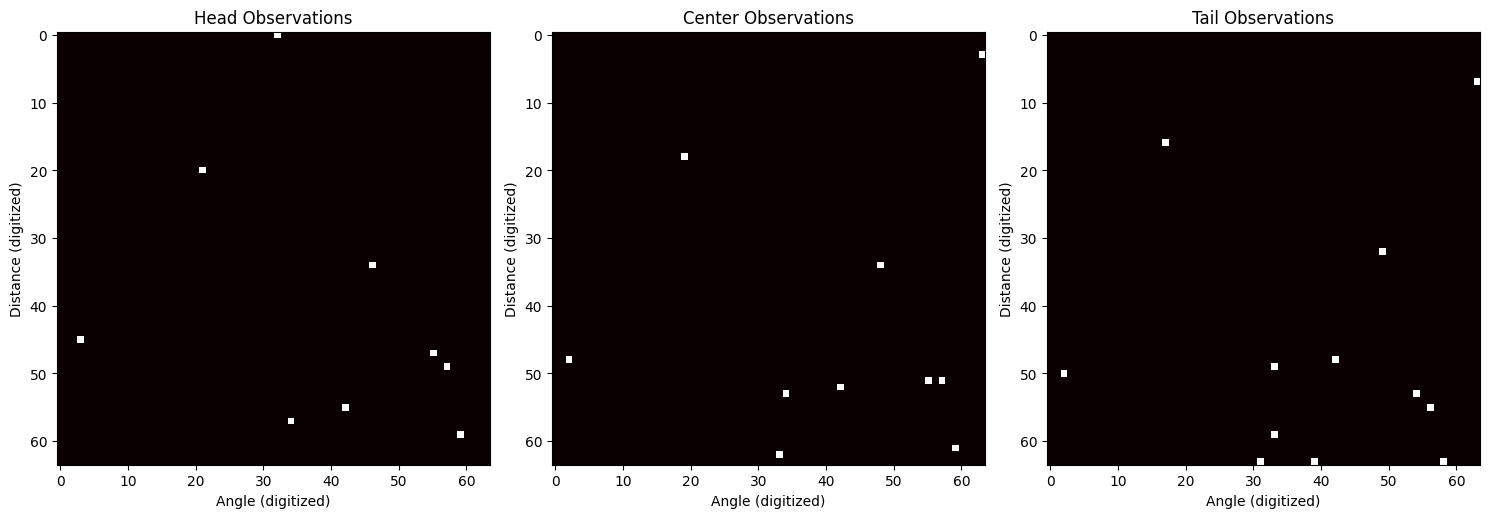

obs_maps_singleFrame_stacked.shape: (100, 64, 64)


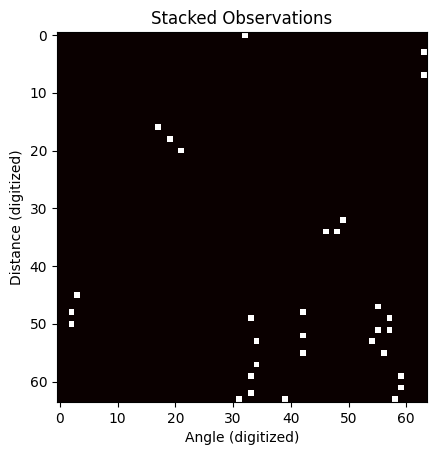

/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/3247989532.py:95: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(v1[:, None, None, :], v2, axis=3),


obs_maps_index.shape: (19526, 4, 64, 64)


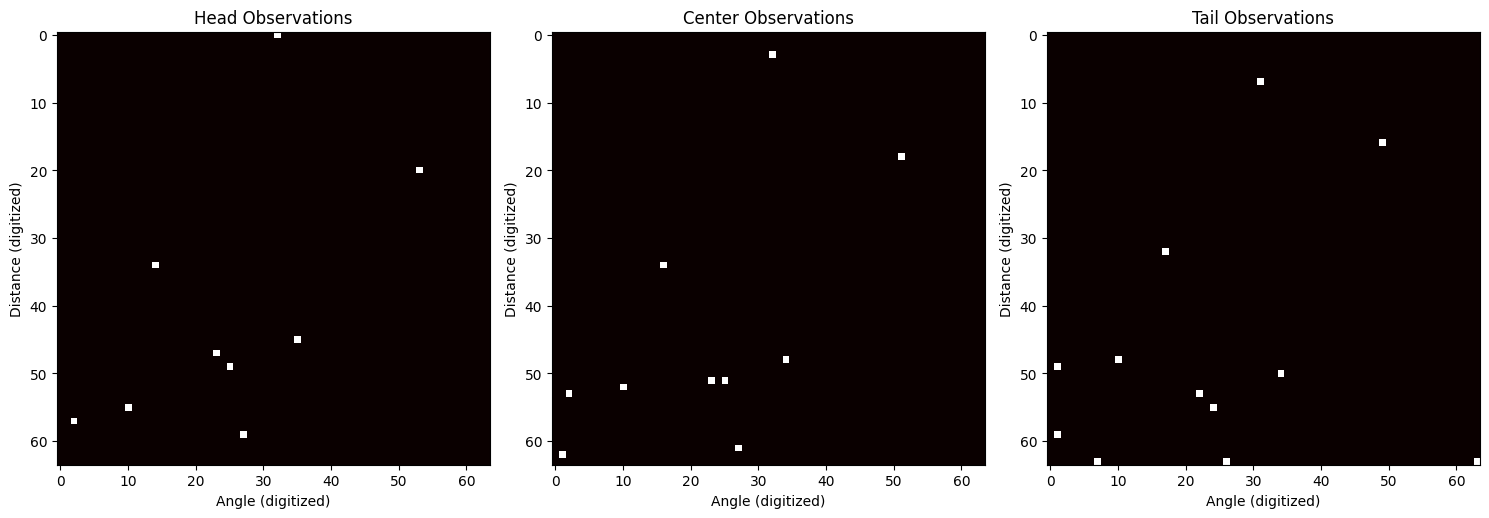

obs_maps_index_stacked.shape: (19526, 64, 64)


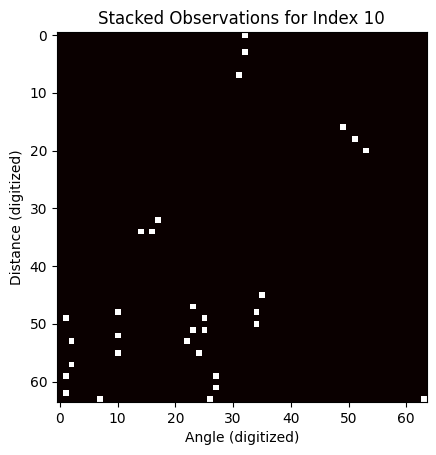

In [5]:
if True:
    # Test get_observed_fish_singleFrame
    obs_maps_singleFrame = get_observed_fish_singleFrame(midline[0], R, obs_maps_single_frame)
    print("obs_maps_singleFrame.shape:", obs_maps_singleFrame.shape)

    # Plot the observation map for the first frame of index 10 as observer
    # 3 sub-figures need to be plotted: head, tail, center into 1 plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Head Observations
    axes[0].imshow(obs_maps_singleFrame[10, 0, :, :], cmap='hot', interpolation='nearest')
    axes[0].set_title('Head Observations')
    axes[0].set_xlabel('Angle (digitized)')
    axes[0].set_ylabel('Distance (digitized)')

    # Center Observations
    axes[1].imshow(obs_maps_singleFrame[10, 1, :, :], cmap='hot', interpolation='nearest')
    axes[1].set_title('Center Observations')
    axes[1].set_xlabel('Angle (digitized)')
    axes[1].set_ylabel('Distance (digitized)')

    # Tail Observations
    axes[2].imshow(obs_maps_singleFrame[10, 2, :, :], cmap='hot', interpolation='nearest')
    axes[2].set_title('Tail Observations')
    axes[2].set_xlabel('Angle (digitized)')
    axes[2].set_ylabel('Distance (digitized)')
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()



    # Stack the 3 observation maps into one
    obs_maps_singleFrame_stacked = np.sum(obs_maps_singleFrame, axis=1)
    obs_maps_singleFrame_stacked = np.where(obs_maps_singleFrame_stacked > 1, 1, obs_maps_singleFrame_stacked)  # Binarize the stacked map
    print("obs_maps_singleFrame_stacked.shape:", obs_maps_singleFrame_stacked.shape)

    # Plot the stacked observation map
    plt.imshow(obs_maps_singleFrame_stacked[10], cmap='hot', interpolation='nearest')
    plt.title('Stacked Observations')
    plt.xlabel('Angle (digitized)')
    plt.ylabel('Distance (digitized)')
    plt.show()



    index = 10  # Example index of the fish to be set as observer
    obs_maps_index = get_observed_fish_index(midline, R, obs_maps_index, index)
    print("obs_maps_index.shape:", obs_maps_index.shape)
    # Plot the observation map for the first frame of index 10 as observer
    # 3 sub-figures need to be plotted: head, tail, center into 1 plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
    # Head Observations
    axes[0].imshow(obs_maps_index[0,0, :, :], cmap='hot', interpolation='nearest')
    axes[0].set_title('Head Observations')
    axes[0].set_xlabel('Angle (digitized)')
    axes[0].set_ylabel('Distance (digitized)')  
    # Center Observations
    axes[1].imshow(obs_maps_index[0,1, :, :], cmap='hot', interpolation='nearest')
    axes[1].set_title('Center Observations')
    axes[1].set_xlabel('Angle (digitized)')
    axes[1].set_ylabel('Distance (digitized)')
    # Tail Observations
    axes[2].imshow(obs_maps_index[0,2, :, :], cmap='hot', interpolation='nearest')
    axes[2].set_title('Tail Observations')
    axes[2].set_xlabel('Angle (digitized)')
    axes[2].set_ylabel('Distance (digitized)')
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  

    # stack the 3 observation maps into one
    obs_maps_index_stacked = np.sum(obs_maps_index, axis=1)
    obs_maps_index_stacked = np.where(obs_maps_index_stacked > 1, 1, obs_maps_index_stacked)  # Binarize the stacked map
    print("obs_maps_index_stacked.shape:", obs_maps_index_stacked.shape)    
    plt.imshow(obs_maps_index_stacked[0], cmap='hot', interpolation='nearest')
    plt.title('Stacked Observations for Index 10')
    plt.xlabel('Angle (digitized)')
    plt.ylabel('Distance (digitized)')
    plt.show()

In [6]:
try:
    road_block
    #test the function for all frames
    obs_maps = get_observed_fish_allFrame(midline, R, obs_maps)
    # Plot the observation map for the first frame of index 10 as observer
    # 3 sub-figures need to be plotted: head, tail, center into 1 plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Head Observations
    axes[0].imshow(obs_maps[0,10, 0, :, :], cmap='hot', interpolation='nearest')
    axes[0].set_title('Head Observations')
    axes[0].set_xlabel('Angle (digitized)')
    axes[0].set_ylabel('Distance (digitized)')  
    # Center Observations
    axes[1].imshow(obs_maps[0,10, 1, :, :], cmap='hot', interpolation='nearest')
    axes[1].set_title('Center Observations')
    axes[1].set_xlabel('Angle (digitized)')
    axes[1].set_ylabel('Distance (digitized)')
    # Tail Observations
    axes[2].imshow(obs_maps[0,10, 2, :, :], cmap='hot', interpolation='nearest')
    axes[2].set_title('Tail Observations')
    axes[2].set_xlabel('Angle (digitized)')
    axes[2].set_ylabel('Distance (digitized)')
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

    #stack the 3 observation maps into one
    obs_maps_stacked = np.sum(obs_maps, axis=1)
    obs_maps_stacked = np.where(obs_maps_stacked > 1, 1, obs_maps_stacked)  # Binarize the stacked map
    print("obs_maps_stacked.shape:", obs_maps_stacked.shape)    
    # Plot the stacked observation map
    plt.imshow(obs_maps_stacked[0,10], cmap='hot', interpolation='nearest')
    plt.title('Stacked Observations')
    plt.xlabel('Angle (digitized)')
    plt.ylabel('Distance (digitized)')
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: name 'road_block' is not defined


### observe boundaries

circle_boundary.shape: (9904, 2)


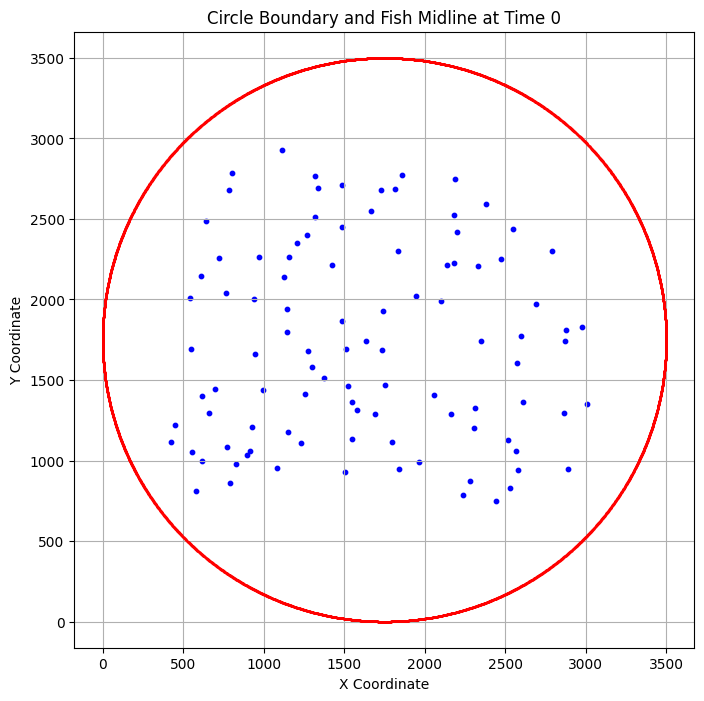

In [7]:
def mid_point_circle_algorithm(radius):
    """
    使用中點圓算法生成圓的邊界點。
    radius: 圓的半徑
    回傳: 圓的邊界點列表 [(x, y), ...]
    """
    points = []
    x = radius
    y = 0
    d = 1 - radius  # 初始決策參數

    while x >= y:
        # 八分之一對稱性
        points.append((x, y))
        points.append((y, x))
        points.append((-x, y))
        points.append((-y, x))
        points.append((-x, -y))
        points.append((-y, -x))
        points.append((x, -y))
        points.append((y, -x))

        y += 1

        if d <= 0:
            d += 2 * y + 1  # 垂直方向移動
        else:
            x -= 1
            d += 2 * y - 2 * x + 1  # 水平方向移動

    return points
# 生成圓的邊界點
circle_boundary = mid_point_circle_algorithm(boundaries_radius)
# 將圓的邊界點轉換為 numpy 陣列
circle_boundary = np.array(circle_boundary)
# 將圓的邊界點平移到 (0, 0)
circle_boundary = circle_boundary + np.array([boundaries_radius, boundaries_radius])
print("circle_boundary.shape:", circle_boundary.shape)
# plot 圓的邊界點 and all the fish midline at time 0 same time
plt.figure(figsize=(8, 8))
plt.plot(circle_boundary[:, 0], circle_boundary[:, 1], 'r.', markersize=1)
plt.scatter(midline[0, :, 1, 0], midline[0, :, 1, 1], c='b', s=10)
plt.title('Circle Boundary and Fish Midline at Time 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.grid()
plt.show()

In [8]:
def get_boundaries_singleFrame(midline, R, circle_boundary, obs_maps_singleFrame):
    pass

def get_boundaries_allFrame(midline, R, circle_boundary, obs_maps):
    pass

def get_boundaries_index(midline, R, circle_boundary, obs_maps_index, index):
    # assume here midline.shape = (T, N, 3, 2)
    # index is the index of the fish we want to set as observer
    #obs_maps_index.shape = (T, 4, grid_size, grid_size)
    #circle_boundary.shape = (N, 2) where N is the number of points on the circle boundary
    T = obs_maps_index.shape[0]  # assume obs_maps_index.shape[0] = T
    N = circle_boundary.shape[0]  # number of points on the circle boundary
    grid_size = obs_maps_index.shape[2]
    
    """ # shape of obs_vector: (T, N, 2)
    obs_vector = np.zeros((T, N, 2))
    print("obs_vector.shape:", obs_vector.shape)  # shape: (T, N, 2)
    obs_vector[:, :, :] = midline[:, index, 1, :].reshape(T, 1, 2) - circle_boundary[None, :, :]
    # get the distance and angle
    obs_distance = np.linalg.norm(obs_vector, axis=2)  # shape: (T, N)
    obs_phi = np.arctan2(obs_vector[:, :, 1], obs_vector[:, :, 0])  # shape: (T, N)
    # check if the distance is within the radius R
    obs_index = obs_distance <= R
    print("obs_index.shape:", obs_index.shape)  # shape: (T, N)
    # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
    obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)  # shape: (T, N)
    obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)  # shape: (T, N)
    # fill the observation map
    # Broadcasting version: update obs_maps_index for all valid observations at once
    idx = np.where(obs_index)
    print("idx:", idx)  # idx will have three arrays: one for each dimension
    # idx will have three arrays: one for each dimension
    # idx[0] is the time index, idx[1] is the circle boundary
    # idx[2] is the body part (head, tail, center)
    obs_maps_index[idx[0], 3, obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1
    # obs_maps_index.shape = (T, 4, grid_size, grid_size)
    # where the 4th channel is the boundary observation
    # obs_maps_index[:, 3, :, :] will contain the boundary observation for each frame """
    # above code may use too many RAM due to large boardcasting
    # use a slower version:
    #for i in tqdm(range(T), desc="Processing frames for boundary observations"):
    for i in range(T):
        obs_vector = np.zeros((N, 2))
        obs_vector[:, :] = midline[i, index, 1, :] - circle_boundary
        # get the distance and angle
        obs_distance = np.linalg.norm(obs_vector, axis=1)  # shape: (N,)
        #obs_phi = np.arctan2(obs_vector[:, 1], obs_vector[:, 0])  # shape: (N,)
        v1 = midline[i, index, 0, :] - midline[i, index, 1, :]  # shape: (2,)
        v2 = obs_vector  # shape: (N, 2)
        obs_phi = np.arctan2(
            np.cross(v1, v2),
            np.sum(v1 * v2, axis=1)
        )  # shape: (N,)
        # print("obs_distance.shape:", obs_distance.shape, "obs_phi.shape:", obs_phi.shape)
        # check if the distance is within the radius R
        obs_index = obs_distance <= R
        # if within the radius, digitize the distance and angle with grid_size and put the value in the observation map
        obs_distance_digitized = np.clip((obs_distance / R) * grid_size, 0, grid_size - 1).astype(int)
        obs_phi_digitized = np.clip((obs_phi + np.pi) / (2 * np.pi) * grid_size, 0, grid_size - 1).astype(int)
        # fill the observation map
        idx = np.where(obs_index)
        # print("idx:", idx)  # idx will have three arrays: one for each dimension
        # idx[0] is the circle boundary, idx[1] is the body part (head, tail, center)
        obs_maps_index[i, 3, obs_distance_digitized[idx], obs_phi_digitized[idx]] = 1
        # print(f"Boundary observations found in frame {i} for index {index}.")
    return obs_maps_index


    

In [9]:
# Test get_observed_fish_index
index = 0  # Example index of the fish to be set as observer
obs_maps_index = get_boundaries_index(midline, R, circle_boundary, obs_maps_index, index)
print("obs_maps_index.shape:", obs_maps_index.shape)
# Plot the observation map for the first frame that index 10 see the wall



/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/3462491656.py:52: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(v1, v2),


obs_maps_index.shape: (19526, 4, 64, 64)


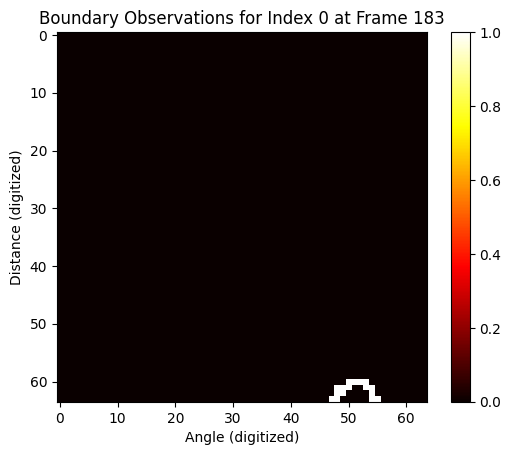

In [10]:
count = 0
for i in range(midline.shape[0]):
    #print(f"Frame {i}:")
    # check if the boundary is observed
    if np.any(obs_maps_index[i, 3, :, :]):
        if count >= 5:  # Show only the first 5 frames where the boundary is observed
            plt.imshow(obs_maps_index[i, 3, :, :], cmap='hot', interpolation='nearest')
            plt.title(f'Boundary Observations for Index {index} at Frame {i}')
            plt.xlabel('Angle (digitized)')
            plt.ylabel('Distance (digitized)')
            plt.colorbar()
            plt.show()
            break
        count += 1

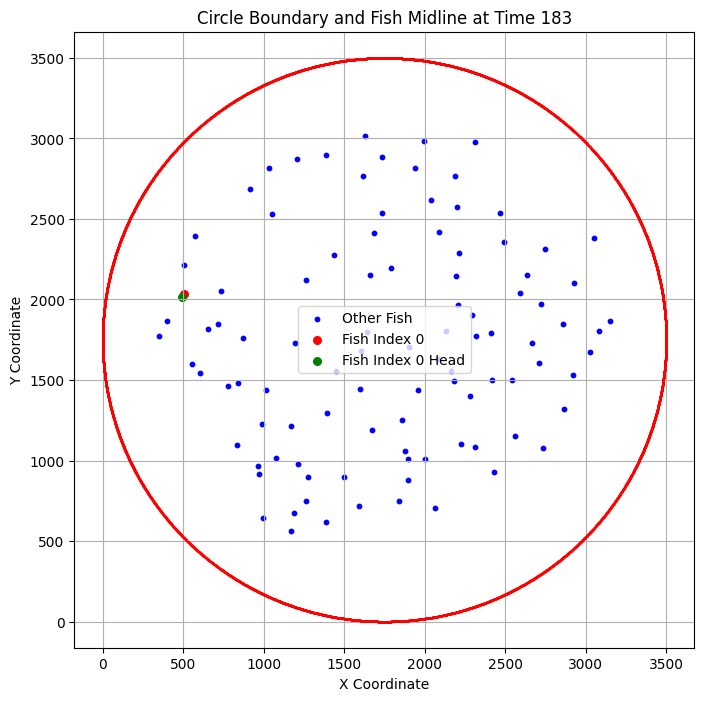

In [11]:
#print all fish and circular boundary at time 180, with index 0 as red dot
plt.figure(figsize=(8, 8))
plt.plot(circle_boundary[:, 0], circle_boundary[:, 1], 'r.', markersize=1)
plt.scatter(midline[183, 1:, 1, 0], midline[183, 1:, 1, 1], c='b', s=10, label='Other Fish')
plt.scatter(midline[183, 0, 1, 0], midline[183, 0, 1, 1], c='r', s=30, label='Fish Index 0')
plt.scatter(midline[183, 0, 0, 0], midline[183, 0, 0, 1], c='g', s=30, label='Fish Index 0 Head')
plt.title('Circle Boundary and Fish Midline at Time 183')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

## prepare data

In [12]:
import os
import re
# Get the last index we stopped for saving observation maps
folder = 'data_100_3_train'
pattern = re.compile(r'total_observation_maps_(\d+)\.npy')
saved_files = [f for f in os.listdir(folder) if pattern.match(f)]
if saved_files:
    last_index = max(int(pattern.match(f).group(1)) for f in saved_files)
    print(f"Last saved index: {last_index}")
else:
    last_index = -1
    print("No saved observation maps found.")


Last saved index: 10


In [13]:


# we need to loop through all index of fish
#by using get_observed_fish_index and get_boundaries_index for each index
#and after we get observations maps of each index, we save them to the same total observation map file for dataset
#so the steps are:
#1. initialize the total observation map file as .npy file
#2. loop through all index of fish
#3. for each index, get the observation map using get_observed_fish_index and get_boundaries_index
#4. save the observation map to the total observation map file (remember dont overwrite the previous index observation map, you need to append it)
#5. after all index are processed, we will have a total observation map file that contains all fish observation maps and boundary observation maps
#6. we can use this total observation map file to train the model

# Loop through all index of fish
for index in tqdm(range(last_index, N), desc="Processing fish indices for observation maps"):
    obs_maps_index = initialize_observation_maps_index(T, grid_size)  # Reinitialize for each index
    # Get the observation map for the current index
    obs_maps_index = get_observed_fish_index(midline, R, obs_maps_index, index)
    # Get the boundary observation map for the current index
    obs_maps_index = get_boundaries_index(midline, R, circle_boundary, obs_maps_index, index)
    # Save the observation map to the total observation map file
     # Assuming we want to save the boundary observations
    # Save the total observation map file in the specified folder
    np.save(f'data_100_3_train/total_observation_maps_{index}.npy', obs_maps_index)
print("Total observation maps saved.")


Processing fish indices for observation maps:   0%|          | 0/90 [00:00<?, ?it/s]/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/3247989532.py:95: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(v1[:, None, None, :], v2, axis=3),
/var/folders/tl/zpq4sgj12s7fy92kwxb81ndc0000gn/T/ipykernel_16325/3462491656.py:52: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(v1, v2),
Processing fish indices for observation maps:   6%|▌         | 5/90 [01:06<18:51, 13.31s/it]


OSError: 319913984 requested and 0 written

# training

## model structure

## train